# Capstone 2 - Diabetes Patients’ Readmission Prediction

## Preprocessing and training

Code written by: Rayees Ahamed

**Steps:**

1. Feature engineering - new features from existing columns (e.g. column1 / column2)
2. Creating dummy features or indicator variables (get_dummies or OneHotEncoder)
3. Scaling the data and verifying it (mean/sd)
4. Correlation maps - (heatmaps, boxplots, scatterplots, pairplot, regplot etc.)
5. Split into train & test sets
6. Save data & summary

## Importing packages

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import os
from library.sb_utils import save_file

import warnings
warnings.filterwarnings('ignore')

## Loading the data

In [2]:
Diabetes = pd.read_csv('data/Diabetes_EDA.csv')
Diabetes.head(10).T

,0,1,2,3,4,5,6,7,8,9
encounter_id,2278392,149190,64410,500364,16680,35754,55842,63768,12522,15738
patient_nbr,8222157,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male,Male,Male,Male,Female,Female
age,[0-10],[10-20],[20-30],[30-40],[40-50],[50-60],[60-70],[70-80],[80-90],[90-100]
admission_type_id,6,1,1,1,1,2,3,1,2,3
discharge_disposition_id,25,1,1,1,1,1,1,1,1,3
admission_source_id,1,7,7,7,7,2,2,7,4,4
time_in_hospital,1,3,2,2,1,3,4,5,13,12
payer_code,?,?,?,?,?,?,?,?,?,?


In [3]:
Diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101763 non-null  int64 
 1   patient_nbr               101763 non-null  int64 
 2   race                      101763 non-null  object
 3   gender                    101763 non-null  object
 4   age                       101763 non-null  object
 5   admission_type_id         101763 non-null  int64 
 6   discharge_disposition_id  101763 non-null  int64 
 7   admission_source_id       101763 non-null  int64 
 8   time_in_hospital          101763 non-null  int64 
 9   payer_code                101763 non-null  object
 10  medical_specialty         101763 non-null  object
 11  num_lab_procedures        101763 non-null  int64 
 12  num_procedures            101763 non-null  int64 
 13  num_medications           101763 non-null  int64 
 14  numb

## Dealing with missing data

Variable weight contains approximate 98% of the missing values so there is no significance in filling those missing values so we decided to drop these variables. Variable Payer code and medical specialty contains approximate 40% missing values so we also dropped these variables. Variables race, diag_1, diag_2, diag_3 and gender contains very less missing values as compared to other attributes which we dropped so for these attributes we also decided to drop those where missing values contains.

In [4]:
#dropping columns with large number of missing values
Diabetes = Diabetes.drop(['payer_code','medical_specialty'], axis = 1)

Variables (drugs named citoglipton and examide), all records have the same value. So essentially these cannot provide any interpretive or discriminatory information for predicting readmission so we decided to drop these two variables

In [5]:
# Removing the discriminatory medicines
Diabetes = Diabetes.drop(['citoglipton', 'examide'], axis = 1)

**Diagnosis columns**

In [6]:
Diabetes['diag_1'].isin(['?']).sum()

21

In [7]:
Diabetes['diag_2'].isin(['?']).sum()

358

In [8]:
Diabetes['diag_3'].isin(['?']).sum()

1423

In [9]:
# Dropping all diag rows with '?' entries

diag_cols = ['diag_1', 'diag_2', 'diag_3']

for col in diag_cols:
    Diabetes.drop(Diabetes[Diabetes[col] == '?'].index, inplace=True)


In [10]:
# Verifying the diag rows
print('diag_1:', Diabetes['diag_1'].isin(['?']).sum())
print('diag_2:', Diabetes['diag_2'].isin(['?']).sum())
print('diag_3:', Diabetes['diag_3'].isin(['?']).sum())

diag_1: 0
diag_2: 0
diag_3: 0


## Feature engineering

This is to generate new features from the existing ones to get more insights on the data. Below columns can be modified and feature engineered to get additional relationship between each column.

**Service utilization**

Service utilization: The data contains variables for number of inpatient (admissions), emergency room visits and outpatient visits for a given patient in the previous one year. These are (crude) measures of how much hospital/clinic services a person has used in the past year. We added these three to create a new variable called service utilization (see figure below). The idea was to see which version gives us better results. Granted, we did not apply any special weighting to the three ingredients of service utilization but we wanted to try something simple at this stage.

In [11]:
Diabetes['service_utilization'] = Diabetes['number_outpatient'] + Diabetes['number_emergency'] + Diabetes['number_inpatient']

**Number of medication changes:** 

The dataset contains 23 features for 23 drugs (or combos) which indicate for each of these, whether a change in that medication was made or not during the current hospital stay of patient. Medication change for diabetics upon admission has been shown by previous research to be associated with lower readmission rates. We decided to count how many changes were made in total for each patient, and declared that a new feature. The reasoning here was to both simplify the model and possibly discover a relationship with number of changes regardless of which drug was changed.

In [12]:
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']
for col in keys:
    colname = str(col) + 'temp'
    Diabetes[colname] = Diabetes[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
Diabetes['numchange'] = 0
for col in keys:
    colname = str(col) + 'temp'
    Diabetes['numchange'] = Diabetes['numchange'] + Diabetes[colname]
    del Diabetes[colname]
    
Diabetes['numchange'].value_counts()  

0    72950
1    25877
2     1301
3      108
4        5
Name: numchange, dtype: int64

#### Age

In [13]:
Diabetes['age'].unique()

array(['[10-20]', '[20-30]', '[30-40]', '[40-50]', '[50-60]', '[60-70]',
       '[70-80]', '[80-90]', '[90-100]', '[0-10]'], dtype=object)

**Object to Numeric conversion:**
* Age column is grouped into different age categories and it is object dtype. 
* We can feature engineer their 'mean' age for each group that can be converted into numeric dtype.

In [14]:
# Creating a dataframe for age
df_age = Diabetes[['age']]

df_age.head()

,age
1,[10-20]
2,[20-30]
3,[30-40]
4,[40-50]
5,[50-60]


In [15]:
# Replacing the brackets '[]' with empty space
df_age['age'] = df_age['age'].str.replace('[', '')
df_age['age'] = df_age['age'].str.replace(']', '')

df_age.head()

,age
1,10-20
2,20-30
3,30-40
4,40-50
5,50-60


In [16]:
# Writing a function to split the age & calculate mean
def split_mean(x):
    split_list = x.split('-')
    mean = (float(split_list[0]) + float(split_list[1])) / 2
    return mean

# Applying the function to get the mean age column
df_age['age_mean'] = df_age['age'].apply(lambda x: split_mean(x))

# Checking the new df
df_age.head()

,age,age_mean
1,10-20,15.0
2,20-30,25.0
3,30-40,35.0
4,40-50,45.0
5,50-60,55.0


In [17]:
# Append the new age column to the original dataframe
Diabetes['age_mean'] = df_age['age_mean']

# Checking the head in original df
Diabetes.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,service_utilization,numchange,age_mean
1,149190,55629189,Caucasian,Female,[10-20],1,1,7,3,59,...,No,No,No,No,Yes,Yes,>30,0,1,15.0
2,64410,86047875,AfricanAmerican,Female,[20-30],1,1,7,2,11,...,No,No,No,No,No,Yes,NO,3,0,25.0
3,500364,82442376,Caucasian,Male,[30-40],1,1,7,2,44,...,No,No,No,No,Yes,Yes,NO,0,1,35.0
4,16680,42519267,Caucasian,Male,[40-50],1,1,7,1,51,...,No,No,No,No,Yes,Yes,NO,0,0,45.0
5,35754,82637451,Caucasian,Male,[50-60],2,1,2,3,31,...,No,No,No,No,No,Yes,>30,0,0,55.0


In [18]:
# Dropping original age column
Diabetes.drop(['age'], axis=1, inplace=True)

**Encoding some variables:**

Encoding some variables: The original dataset used string values for gender, race, medication change, and each of the 23 drugs used. To better fit those variables into our model, we interpret the variables to numeric binary variables to reflect their nature. For example, we encoded the “ medication change ” feature from “No” (no change) and “Yes” (changed) into 0 and 1.

In [19]:
Diabetes['change'].value_counts()

No     53891
Yes    46350
Name: change, dtype: int64

In [20]:
Diabetes['diabetesMed'].value_counts()

Yes    77153
No     23088
Name: diabetesMed, dtype: int64

In [21]:
# Encoding variables
Diabetes['change'] = Diabetes['change'].replace('Yes', 1)
Diabetes['change'] = Diabetes['change'].replace('No', 0)
Diabetes['gender'] = Diabetes['gender'].replace('Male', 1)
Diabetes['gender'] = Diabetes['gender'].replace('Female', 0)
Diabetes['diabetesMed'] = Diabetes['diabetesMed'].replace('Yes', 1)
Diabetes['diabetesMed'] = Diabetes['diabetesMed'].replace('No', 0)
# keys is the same as before
for col in keys:
    Diabetes[col] = Diabetes[col].replace('No', 0)
    Diabetes[col] = Diabetes[col].replace('Steady', 1)
    Diabetes[col] = Diabetes[col].replace('Up', 1)
    Diabetes[col] = Diabetes[col].replace('Down', 1)

We also reduced both A1C test result and Glucose serum test result into categories of Normal, Abnormal and Not tested.


In [22]:
Diabetes['A1Cresult'] = Diabetes['A1Cresult'].replace('>7', 1)
Diabetes['A1Cresult'] = Diabetes['A1Cresult'].replace('>8', 1)
Diabetes['A1Cresult'] = Diabetes['A1Cresult'].replace('Norm', 0)
Diabetes['A1Cresult'] = Diabetes['A1Cresult'].replace('None', -99)
Diabetes['max_glu_serum'] = Diabetes['max_glu_serum'].replace('>200', 1)
Diabetes['max_glu_serum'] = Diabetes['max_glu_serum'].replace('>300', 1)
Diabetes['max_glu_serum'] = Diabetes['max_glu_serum'].replace('Norm', 0)
Diabetes['max_glu_serum'] = Diabetes['max_glu_serum'].replace('None', -99)

In [23]:
Diabetes.shape

(100241, 47)

Collapsing of Multiple Encounters for same patient Some patients in the dataset had more than one encounter.We could not count them as independent encounters because that bias the results towards those patients who had multiple encounters. Thus we tried multiple techniques to collapse and consolidate multiple encounters for same patient such as:

Considering more than 2 readmissions across multiple encounters as readmission for collapsed record.
Considering average stay at hospital across multiple encounters.
Considering the percentage of the medication changes across multiple encounters
Considering the total number of the encounters to replace the encounter unique ID
Considering the combination of diagnoses across multiple encounters as a list However, taking the features such as “diagnosis”, for instance, we did not find it not meaningful to combine multiple categorical values into an array for building data model. We then considered first encounter and last encounter separately as possible representations of multiple encounters. However, last encounters gave extremely imbalanced data for readmissions (96/4 Readmissions vs No Readmissions) and thus, we decided to use first encounters of patients with multiple encounters. This resulted in dataset being reduced to about 70,000 encounters:

In [24]:
Diabetes = Diabetes.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
Diabetes.shape

(70413, 47)

In [25]:
Diabetes.head(10).T

,1,2,3,4,5,6,7,8,9,10
encounter_id,149190,64410,500364,16680,35754,55842,63768,12522,15738,28236
patient_nbr,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939,89869032
race,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,AfricanAmerican
gender,0,0,1,1,1,1,1,0,0,0
admission_type_id,1,1,1,1,2,3,1,2,3,1
discharge_disposition_id,1,1,1,1,1,1,1,1,3,1
admission_source_id,7,7,7,7,2,2,7,4,4,7
time_in_hospital,3,2,2,1,3,4,5,13,12,9
num_lab_procedures,59,11,44,51,31,70,73,68,33,47
num_procedures,0,5,1,0,6,1,0,2,3,2


### Encoding target variable

In [26]:
Diabetes['readmitted'].value_counts()

NO     42145
>30    22018
<30     6250
Name: readmitted, dtype: int64

In [27]:
# Converting to binary class
Diabetes['readmitted'] = Diabetes['readmitted'].replace('>30', 0)
Diabetes['readmitted'] = Diabetes['readmitted'].replace('<30', 1)
Diabetes['readmitted'] = Diabetes['readmitted'].replace('NO', 0)

**Age_mean vs readmitted (target variable)**

Now we can check the newly created **age_mean** against target variable.

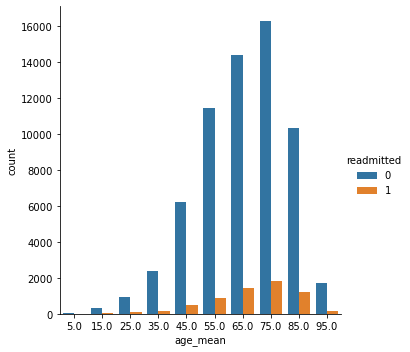

In [28]:
# Category plot to show the distribution of readmitted count
sns.catplot(x='age_mean', data=Diabetes, kind='count', hue='readmitted')
plt.show()

**Observation from Age_Mean vs Readmitted:**

* Age plays critical role in hospital readmission
* As diabetes people age, they high chance of getting readmitted

#### Time in hospital

In [29]:
# Checking the time_in_hospital column
Diabetes['time_in_hospital'].unique()

array([ 3,  2,  1,  4,  5, 13, 12,  9,  7, 10,  6, 11,  8, 14],
      dtype=int64)

#### Glucose levels (max_glu_serum)

In [30]:
# Checking glucose level indicators
Diabetes['max_glu_serum'].unique()

array([-99,   1,   0], dtype=int64)

**Glycated hemoglobin levels (A1Cresult)**

In [31]:
# Checking A1C result levels
Diabetes['A1Cresult'].unique()

array([-99,   1,   0], dtype=int64)

In [32]:
Diabetes.dtypes

encounter_id                  int64
patient_nbr                   int64
race                         object
gender                        int64
admission_type_id             int64
discharge_disposition_id      int64
admission_source_id           int64
time_in_hospital              int64
num_lab_procedures            int64
num_procedures                int64
num_medications               int64
number_outpatient             int64
number_emergency              int64
number_inpatient              int64
diag_1                       object
diag_2                       object
diag_3                       object
number_diagnoses              int64
max_glu_serum                 int64
A1Cresult                     int64
metformin                     int64
repaglinide                   int64
nateglinide                   int64
chlorpropamide                int64
glimepiride                   int64
acetohexamide                 int64
glipizide                     int64
glyburide                   

In [33]:
# convert data type of nominal features in dataframe to 'object' type
i = ['encounter_id', 'patient_nbr', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',\
            'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', \
          'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose','miglitol', \
          'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', \
          'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', \
          'age_mean', 'A1Cresult', 'max_glu_serum']

Diabetes[i] = Diabetes[i].astype('object')

In [34]:
Diabetes.dtypes

encounter_id                object
patient_nbr                 object
race                        object
gender                      object
admission_type_id           object
discharge_disposition_id    object
admission_source_id         object
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide                   object
tolbutamide         

**Number of medication used:** 

Another possibly related factor could be the total number of medications used by the patient (which may indicate severity of their condition and/or the intensity of care). So we created another feature by counting the medications used during the encounter (keys variable in code below is continued from above):

In [35]:
Diabetes['nummed'] = 0

for col in keys:
    Diabetes['nummed'] = Diabetes['nummed'] + Diabetes[col]
Diabetes['nummed'].value_counts()

1    31359
0    16960
2    15399
3     5636
4     1005
5       50
6        4
Name: nummed, dtype: int64

In [36]:
df = Diabetes

In [37]:
# get list of only numeric features
num_col = list(set(list(df._get_numeric_data().columns))- {'readmitted'})
num_col

['numchange',
 'num_medications',
 'number_inpatient',
 'number_diagnoses',
 'num_procedures',
 'number_emergency',
 'time_in_hospital',
 'number_outpatient',
 'service_utilization',
 'num_lab_procedures']

In [38]:
# Removing skewnewss and kurtosis using log transformation if it is above a threshold value -  2

statdataframe = pd.DataFrame()
statdataframe['numeric_column'] = num_col
skew_before = []
skew_after = []

kurt_before = []
kurt_after = []

standard_deviation_before = []
standard_deviation_after = []

log_transform_needed = []

log_type = []

for i in num_col:
    skewval = df[i].skew()
    skew_before.append(skewval)
    
    kurtval = df[i].kurtosis()
    kurt_before.append(kurtval)
    
    sdval = df[i].std()
    standard_deviation_before.append(sdval)
    
    if (abs(skewval) >2) & (abs(kurtval) >2):
        log_transform_needed.append('Yes')
        
        if len(df[df[i] == 0])/len(df) <=0.02:
            log_type.append('log')
            skewvalnew = np.log(pd.DataFrame(df[train_data[i] > 0])[i]).skew()
            skew_after.append(skewvalnew)
            
            kurtvalnew = np.log(pd.DataFrame(df[train_data[i] > 0])[i]).kurtosis()
            kurt_after.append(kurtvalnew)
            
            sdvalnew = np.log(pd.DataFrame(df[train_data[i] > 0])[i]).std()
            standard_deviation_after.append(sdvalnew)
            
        else:
            log_type.append('log1p')
            skewvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).skew()
            skew_after.append(skewvalnew)
        
            kurtvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).kurtosis()
            kurt_after.append(kurtvalnew)
            
            sdvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).std()
            standard_deviation_after.append(sdvalnew)
            
    else:
        log_type.append('NA')
        log_transform_needed.append('No')
        
        skew_after.append(skewval)
        kurt_after.append(kurtval)
        standard_deviation_after.append(sdval)

statdataframe['skew_before'] = skew_before
statdataframe['kurtosis_before'] = kurt_before
statdataframe['standard_deviation_before'] = standard_deviation_before
statdataframe['log_transform_needed'] = log_transform_needed
statdataframe['log_type'] = log_type
statdataframe['skew_after'] = skew_after
statdataframe['kurtosis_after'] = kurt_after
statdataframe['standard_deviation_after'] = standard_deviation_after

In [39]:
statdataframe

,numeric_column,skew_before,kurtosis_before,standard_deviation_before,log_transform_needed,log_type,skew_after,kurtosis_after,standard_deviation_after
0,numchange,1.599940,2.057294,0.475862,No,NA,1.599940,2.057294,0.475862
1,num_medications,1.436853,3.842213,8.300829,No,NA,1.436853,3.842213,8.300829
2,number_inpatient,5.438807,44.671256,0.608228,Yes,log1p,3.062918,9.683472,0.300091
3,number_diagnoses,-0.650645,-0.627605,1.892577,No,NA,-0.650645,-0.627605,1.892577
4,num_procedures,1.208349,0.501410,1.766029,No,NA,1.208349,0.501410,1.766029
5,number_emergency,21.127063,1203.717527,0.511620,Yes,log1p,4.238371,21.178410,0.229786
6,time_in_hospital,1.158741,0.935930,2.956908,No,NA,1.158741,0.935930,2.956908
7,number_outpatient,9.635196,180.709032,1.075494,Yes,log1p,3.138552,10.562816,0.381826
8,service_utilization,6.645610,96.293589,1.440084,Yes,log1p,1.886177,3.174547,0.506795
9,num_lab_procedures,-0.215869,-0.289554,19.976132,No,NA,-0.215869,-0.289554,19.976132


In [40]:
# performing the log transformation for the columns determined to be needing it above.

for i in range(len(statdataframe)):
    if statdataframe['log_transform_needed'][i] == 'Yes':
        colname = str(statdataframe['numeric_column'][i])
        
        if statdataframe['log_type'][i] == 'log':
            df = df[df[colname] > 0]
            df[colname + "_log"] = np.log(df[colname])
            
        elif statdataframe['log_type'][i] == 'log1p':
            df = df[df[colname] >= 0]
            df[colname + "_log1p"] = np.log1p(df[colname])

In [41]:
df = df.drop(['number_outpatient', 'number_inpatient', 'number_emergency','service_utilization'], axis = 1)

In [42]:
df.shape

(70413, 48)

In [43]:
# get list of only numeric features
numerics = list(set(list(df._get_numeric_data().columns))- {'readmitted'})
numerics

['numchange',
 'num_medications',
 'service_utilization_log1p',
 'number_outpatient_log1p',
 'number_emergency_log1p',
 'number_diagnoses',
 'num_procedures',
 'number_inpatient_log1p',
 'time_in_hospital',
 'num_lab_procedures']

In [44]:
# show list of features that are categorical
df.encounter_id = df.encounter_id.astype('int64')
df.patient_nbr = df.patient_nbr.astype('int64')
df.diabetesMed = df.diabetesMed.astype('int64')
df.change = df.change.astype('int64')

# convert data type of nominal features in dataframe to 'object' type for aggregating
i = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', \
          'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose','miglitol', \
          'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', \
          'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone','A1Cresult']
df[i] = df[i].astype('int64')

df.dtypes

encounter_id                   int64
patient_nbr                    int64
race                          object
gender                        object
admission_type_id             object
discharge_disposition_id      object
admission_source_id           object
time_in_hospital               int64
num_lab_procedures             int64
num_procedures                 int64
num_medications                int64
diag_1                        object
diag_2                        object
diag_3                        object
number_diagnoses               int64
max_glu_serum                 object
A1Cresult                      int64
metformin                      int64
repaglinide                    int64
nateglinide                    int64
chlorpropamide                 int64
glimepiride                    int64
acetohexamide                  int64
glipizide                      int64
glyburide                      int64
tolbutamide                    int64
pioglitazone                   int64
r

In [45]:
dfcopy = df.copy(deep = True)

In [46]:
df['readmitted'] = df['readmitted'].apply(lambda x: 0 if x == 2 else x)

In [47]:
# drop individual diagnosis columns that have too granular disease information
# also drop level 2 categorization (which was not comparable with any reference)
# also drop level 1 secondary and tertiary diagnoses
df.drop(['diag_1', 'diag_2', 'diag_3'], axis=1, inplace=True)

In [48]:
interactionterms = [('num_medications','time_in_hospital'),
('num_medications','num_procedures'),
('time_in_hospital','num_lab_procedures'),
('num_medications','num_lab_procedures'),
('num_medications','number_diagnoses'),
('age_mean','number_diagnoses'),
('change','num_medications'),
('number_diagnoses','time_in_hospital'),
('num_medications','numchange')]

In [49]:
for inter in interactionterms:
    name = inter[0] + '|' + inter[1]
    df[name] = df[inter[0]] * df[inter[1]]

In [50]:
df[['num_medications','time_in_hospital', 'num_medications|time_in_hospital']].head()

,num_medications,time_in_hospital,num_medications|time_in_hospital
1,18,3,54
2,13,2,26
3,16,2,32
4,8,1,8
5,16,3,48


In [51]:
df.head().T

,1,2,3,4,5
encounter_id,149190,64410,500364,16680,35754
patient_nbr,55629189,86047875,82442376,42519267,82637451
race,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian
gender,0,0,1,1,1
admission_type_id,1,1,1,1,2
discharge_disposition_id,1,1,1,1,1
admission_source_id,7,7,7,7,2
time_in_hospital,3,2,2,1,3
num_lab_procedures,59,11,44,51,31
num_procedures,0,5,1,0,6


### Checking missing values once

In [52]:
df.isna().sum()

encounter_id                           0
patient_nbr                            0
race                                   0
gender                                 0
admission_type_id                      0
discharge_disposition_id               0
admission_source_id                    0
time_in_hospital                       0
num_lab_procedures                     0
num_procedures                         0
num_medications                        0
number_diagnoses                       0
max_glu_serum                          0
A1Cresult                              0
metformin                              0
repaglinide                            0
nateglinide                            0
chlorpropamide                         0
glimepiride                            0
acetohexamide                          0
glipizide                              0
glyburide                              0
tolbutamide                            0
pioglitazone                           0
rosiglitazone   

### Checking for duplicated rows

In [53]:
duplicate_df = df[df.duplicated()]
duplicate_df

,encounter_id,patient_nbr,race,gender,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,service_utilization_log1p,num_medications|time_in_hospital,num_medications|num_procedures,time_in_hospital|num_lab_procedures,num_medications|num_lab_procedures,num_medications|number_diagnoses,age_mean|number_diagnoses,change|num_medications,number_diagnoses|time_in_hospital,num_medications|numchange


### Categorical features dataframe

Creating dataframe containing only categorical variables.

In [54]:
df_object = df.select_dtypes(include='object')
df_object.nunique()

race                          5
gender                        2
admission_type_id             8
discharge_disposition_id     26
admission_source_id          17
max_glu_serum                 3
age_mean                     10
nummed                        7
age_mean|number_diagnoses    87
dtype: int64

### Correlation heatmap for numeric features

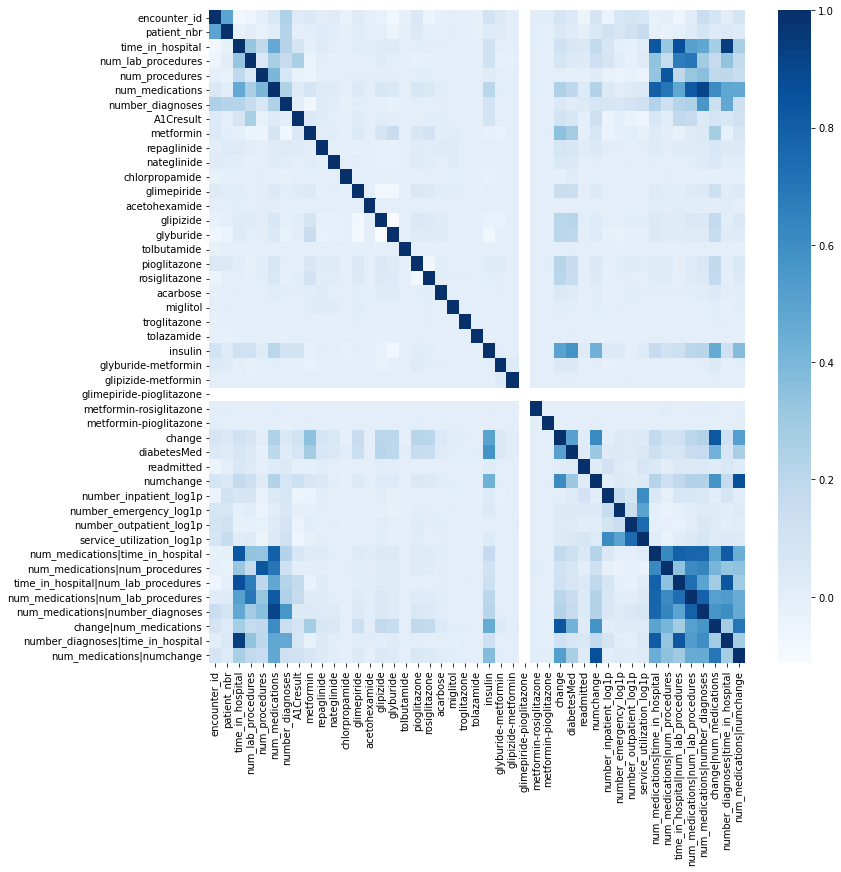

In [58]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), cmap='Blues')
plt.show()

**Observations from heatmap:**

* time_in_hospital & num_medications - positively correlated
* num_procedures & num_medications - positively correlated
* age_mean & num_emergency - negatively correlated

In [60]:
df['glimepiride-pioglitazone'].unique()

array([0], dtype=int64)

In [62]:
df.drop(['glimepiride-pioglitazone'], axis=1, inplace=True)

### Checking for outliers


In [ ]:
# Boxplot to check the outliers
df_num = df.select_dtypes(exclude='object')

for col in df_num.columns:
    plt.figure(figsize=(4,4))
    sns.boxplot(x=df_num[col])
plt.show()

### Removing the uncessary columns

In [68]:
# Columns to drop
columns_to_drop =['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']

# Dropping unneccessary columns
df_copy = df.drop(columns_to_drop, axis=1)

In [69]:
df_copy.columns

Index(['race', 'gender', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'numchange', 'age_mean', 'nummed', 'number_inpatient_log1p',
       'number_emergency_log1p', 'number_outpatient_log1p',
       'service_utilization_log1p', 'num_medications|time_in_hospital',
       'num_medications|num_procedures', 'time_in_hospital|num_lab_procedures',
       'num_medications|num_lab_procedures',
       'num_medications|number_diagnoses', 'age_mean|number_diagnoses',
       'change|num_medications

## Creating dummy features for categorical variables

In [ ]:
# Dropping 'y' variable - redmitted & assigning the 'X'
X = Diabetes.drop('readmitted', axis=1)

In [ ]:
# Getting dummies & assigning to X variable
X = pd.get_dummies(X)

# y variable
y = Diabetes['readmitted']

In [ ]:
X.head()

In [ ]:
y.head()

## Splitting the training and test data

In [ ]:
# Train & test set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=111)

In [ ]:
# Verifying X shape
X_train.shape, X_test.shape

In [ ]:
# Verifying y shape
y_train.shape, y_test.shape

## Scaling the data

In [ ]:
# Making a scaler object
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Verifying the scaling

In [ ]:
# Verifying the mean of scaled_df (mean =0)
X_train_scaled.mean()

In [ ]:
# Verifying the standard deviation (std = 1)
X_test_scaled.std(ddof=0)

In [ ]:
y_test

## Summary & next steps

* We feature engineered 'age' column from category to numeric by converting into age_mean.
* We observed aged people have high chance of getting readmitted
* We inspected the missing values, duplicated rows and outliers in the data
* Plotted the correlation heatmap for the numeric features - num_medications positively correlated with time_in_hospital, age_mean negatively correlated with num_emergency
* Followed by we scaled and verified the data
* Created the training and test sets from the original dataframe

**Next steps:**
* Choosing 2 to 3 type of different models to train the dataset.
* Analysing their performance metrics
* Selecting the best model and deploying it.

**Saving the data**

In [70]:
datapath = 'data/'

# Saving the processed dataframe
save_file(df_copy, 'Diabetes_SOLVED_NEW.csv', datapath)

Writing file.  "data/Diabetes_SOLVED_NEW.csv"
